### Mount

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/300/'

os.chdir(current_path)

### Load data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.chdir(current_path)


interval = '30m'
date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path = './candlestick_concated/%s/2021-05-17/' % interval
file_list = os.listdir(date_path)

print((file_list))

['2021-05-17 BTCUSDT.xlsx', '2021-05-17 ETHUSDT.xlsx', '2021-05-17 BCHUSDT.xlsx', '2021-05-17 XRPUSDT.xlsx', '2021-05-17 EOSUSDT.xlsx', '2021-05-17 LTCUSDT.xlsx', '2021-05-17 ETCUSDT.xlsx', '2021-05-17 LINKUSDT.xlsx', '2021-05-17 XLMUSDT.xlsx', '2021-05-17 ADAUSDT.xlsx', '2021-05-17 XMRUSDT.xlsx', '2021-05-17 SXPUSDT.xlsx', '2021-05-17 KAVAUSDT.xlsx', '2021-05-17 BANDUSDT.xlsx', '2021-05-17 DASHUSDT.xlsx', '2021-05-17 ZECUSDT.xlsx', '2021-05-17 XTZUSDT.xlsx', '2021-05-17 BNBUSDT.xlsx', '2021-05-17 ATOMUSDT.xlsx', '2021-05-17 ONTUSDT.xlsx', '2021-05-17 IOTAUSDT.xlsx', '2021-05-17 BATUSDT.xlsx', '2021-05-17 NEOUSDT.xlsx', '2021-05-17 QTUMUSDT.xlsx', '2021-05-17 WAVESUSDT.xlsx', '2021-05-17 MKRUSDT.xlsx', '2021-05-17 SNXUSDT.xlsx', '2021-05-17 DOTUSDT.xlsx', '2021-05-17 THETAUSDT.xlsx', '2021-05-17 ALGOUSDT.xlsx', '2021-05-17 KNCUSDT.xlsx', '2021-05-17 ZRXUSDT.xlsx', '2021-05-17 COMPUSDT.xlsx', '2021-05-17 OMGUSDT.xlsx']


### basic fishing (not concerned about rapid descending)

start_stamp : 0


len(ohlcv) : 12856


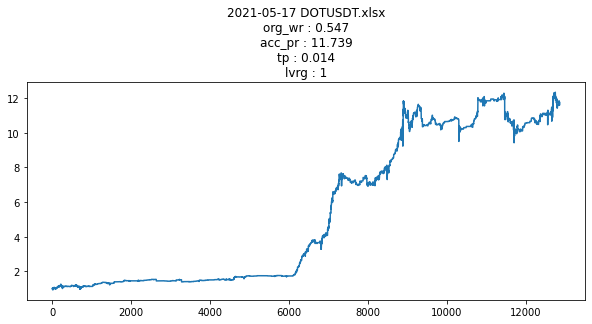

In [ ]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(3, 7)
lvrg_list = range(6, 10)
lvrg_list = range(1, 2)
# lvrg_list = range(5, 6)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:
      
      #       tp opt      #
      best_tp = None
      best_ap = 0
      best_pr = None

      #        find best tp       #
      for tp in tp_list:

        long_ep = ohlcv['close'].shift(1) * (1 / (tp + 1))

        #       long      #
        pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(ohlcv['low'] < long_ep, pr, 1)
      
        lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       short       #
        # s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)
        # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

        # plt.plot(np.cumprod(pr))
        # plt.title("%.3f" % tp)
        # plt.show()
        # plt.close()

        ap = np.cumprod(pr)[-1]
        if ap >= best_ap:
          best_ep = long_ep
          best_ap = ap
          best_tp = tp
          best_pr = pr

      best_pr = np.array(best_pr)
      org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

      plt.figure(figsize=(10, 4))
      # plt.subplot(121)
      plt.plot(np.cumprod(best_pr))
      plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))

      
      #     avoid dropping    #      
      # ema = ohlcv['close'].ewm(span=190, min_periods=190-1, adjust=False).mean()
      # # avoid_pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), test_pr, 1)

      # avoid_pr = np.where(ema.shift(1) > ema.shift(2), best_pr, 1)

      # # ma = ohlcv['close'].rolling(120).mean()
      # # avoid_pr = np.where(ma.shift(1) > ma.shift(2), best_pr, 1)

      # avoid_wr = len(avoid_pr[avoid_pr > 1]) / len(avoid_pr[avoid_pr != 1])

      
      # plt.subplot(122)
      # plt.plot(np.cumprod(avoid_pr))
      # plt.title("%s\navoid_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, avoid_wr, np.cumprod(avoid_pr)[-1], best_tp, lvrg))

      plt.show()








### get constraint's tp

start_stamp : 0


len(ohlcv) : 12856


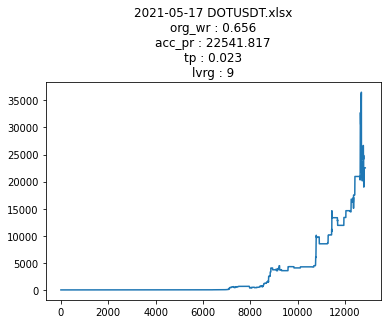

In [6]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(3, 7)
lvrg_list = range(9, 10)
# lvrg_list = range(1, 2)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:
      
      #       tp opt      #
      best_tp = None
      best_ap = 0
      best_pr = None

      #        find best tp       #
      for tp in tp_list:

        long_ep = ohlcv['close'].shift(1) * (1 / (tp + 1))

        #       long      #
        pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(ohlcv['low'] < long_ep, pr, 1)

        #     set constraints     #

        #           ema           #
        ema = ohlcv['close'].ewm(span=190, min_periods=190-1, adjust=False).mean()
        # pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), pr, 1)
        pr = np.where(ema.shift(1) > ema.shift(2), pr, 1)

        #         ma        #
        # ma = ohlcv['close'].rolling(120).mean()
        # pr = np.where(ma.shift(1) > ma.shift(2), pr, 1)

      
        lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)
        # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

        # plt.plot(np.cumprod(pr))
        # plt.title("%.3f" % tp)
        # plt.show()
        # plt.close()

        wr = len(pr[pr > 1]) / len(pr[pr != 1])

        ap = np.cumprod(pr)[-1]
        # if ap >= best_ap:
        if ap >= best_ap and wr > 0.65:
          best_ep = long_ep
          best_ap = ap
          best_tp = tp
          best_pr = pr

      best_pr = np.array(best_pr)
      org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

      plt.figure(figsize=(6, 4))
      # plt.subplot(121)
      plt.plot(np.cumprod(best_pr))
      plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))
      
      plt.show()








### sell high

#### extract traded index

In [15]:
print(len(ohlcv))
print(len(best_pr))

traded_index = ohlcv.index[best_pr != 1]

print(len(traded_index))
print(len(best_pr[best_pr != 1]))

print((traded_index))


12856
12856
442
442
DatetimeIndex(['2020-08-26 15:59:59.999000', '2020-08-26 16:29:59.999000', '2020-08-26 20:59:59.999000', '2020-08-27 01:29:59.999000', '2020-08-27 02:29:59.999000', '2020-08-27 05:59:59.999000', '2020-08-27 06:29:59.999000', '2020-08-27 07:59:59.999000', '2020-08-27 11:29:59.999000', '2020-08-27 11:59:59.999000',
               ...
               '2021-05-15 13:59:59.999000', '2021-05-15 15:59:59.999000', '2021-05-15 16:29:59.999000', '2021-05-15 18:29:59.999000', '2021-05-15 19:29:59.999000', '2021-05-16 00:59:59.999000', '2021-05-16 01:29:59.999000', '2021-05-16 04:29:59.999000', '2021-05-16 07:29:59.999000', '2021-05-16 07:59:59.999000'], dtype='datetime64[ns]', length=442, freq=None)


In [13]:
interval = '1m'
# date_path = './candlestick_concated/%s/2021-04-27/' % interval
date_path2 = './candlestick_concated/%s/2021-05-17/' % interval
file_list2 = os.listdir(date_path)

print((file_list2))

['2021-05-17 BTCUSDT.xlsx', '2021-05-17 ETHUSDT.xlsx', '2021-05-17 BCHUSDT.xlsx', '2021-05-17 XRPUSDT.xlsx', '2021-05-17 EOSUSDT.xlsx', '2021-05-17 LTCUSDT.xlsx', '2021-05-17 ETCUSDT.xlsx', '2021-05-17 LINKUSDT.xlsx', '2021-05-17 XLMUSDT.xlsx', '2021-05-17 ADAUSDT.xlsx', '2021-05-17 XMRUSDT.xlsx', '2021-05-17 SXPUSDT.xlsx', '2021-05-17 KAVAUSDT.xlsx', '2021-05-17 BANDUSDT.xlsx', '2021-05-17 DASHUSDT.xlsx', '2021-05-17 ZECUSDT.xlsx', '2021-05-17 XTZUSDT.xlsx', '2021-05-17 BNBUSDT.xlsx', '2021-05-17 ATOMUSDT.xlsx', '2021-05-17 ONTUSDT.xlsx', '2021-05-17 IOTAUSDT.xlsx', '2021-05-17 BATUSDT.xlsx', '2021-05-17 NEOUSDT.xlsx', '2021-05-17 QTUMUSDT.xlsx', '2021-05-17 WAVESUSDT.xlsx', '2021-05-17 MKRUSDT.xlsx', '2021-05-17 SNXUSDT.xlsx', '2021-05-17 DOTUSDT.xlsx', '2021-05-17 THETAUSDT.xlsx', '2021-05-17 ALGOUSDT.xlsx', '2021-05-17 KNCUSDT.xlsx', '2021-05-17 ZRXUSDT.xlsx', '2021-05-17 COMPUSDT.xlsx', '2021-05-17 OMGUSDT.xlsx']


In [16]:
ohlcv2 = pd.read_excel(date_path2 + key, index_col=0)
print('len(ohlcv2) :', len(ohlcv2))

print(ohlcv2.index)

len(ohlcv2) : 15840
DatetimeIndex(['2021-05-07 00:00:59.999000', '2021-05-07 00:01:59.999000', '2021-05-07 00:02:59.999000', '2021-05-07 00:03:59.999000', '2021-05-07 00:04:59.999000', '2021-05-07 00:05:59.999000', '2021-05-07 00:06:59.999000', '2021-05-07 00:07:59.999000', '2021-05-07 00:08:59.999000', '2021-05-07 00:09:59.999000',
               ...
               '2021-05-17 23:50:59.999000', '2021-05-17 23:51:59.999000', '2021-05-17 23:52:59.999000', '2021-05-17 23:53:59.999000', '2021-05-17 23:54:59.999000', '2021-05-17 23:55:59.999000', '2021-05-17 23:56:59.999000', '2021-05-17 23:57:59.999000', '2021-05-17 23:58:59.999000', '2021-05-17 23:59:59.999000'], dtype='datetime64[ns]', length=15840, freq=None)


#### match timeline

In [25]:
# matching 된 tick 포함해서 이전 30개의 틱을 조사한다

traded_i = []
for i in range(len(ohlcv2.index)):

  if ohlcv2.index[i] in traded_index:
    traded_i.append(i)

print(len(traded_i))

43


#### do survey

In [27]:
!pip install mpl_finance

In [ ]:
best_ep2 = best_ep.loc[ohlcv2.index[traded_i]]
print(best_ep2)

DatetimeIndex(['2021-05-07 00:59:59.999000', '2021-05-07 02:59:59.999000', '2021-05-07 03:59:59.999000', '2021-05-07 04:29:59.999000', '2021-05-07 11:59:59.999000', '2021-05-08 06:29:59.999000', '2021-05-08 07:29:59.999000', '2021-05-08 07:59:59.999000', '2021-05-12 19:59:59.999000', '2021-05-12 23:59:59.999000', '2021-05-13 00:29:59.999000', '2021-05-13 00:59:59.999000', '2021-05-13 01:29:59.999000', '2021-05-13 01:59:59.999000', '2021-05-13 03:29:59.999000', '2021-05-13 07:29:59.999000', '2021-05-13 14:29:59.999000', '2021-05-13 14:59:59.999000', '2021-05-13 16:29:59.999000', '2021-05-13 17:29:59.999000', '2021-05-13 17:59:59.999000', '2021-05-13 22:29:59.999000', '2021-05-14 01:59:59.999000', '2021-05-14 02:29:59.999000', '2021-05-14 03:59:59.999000', '2021-05-14 06:59:59.999000', '2021-05-14 11:29:59.999000', '2021-05-14 15:29:59.999000', '2021-05-15 00:59:59.999000', '2021-05-15 01:29:59.999000', '2021-05-15 05:59:59.999000', '2021-05-15 09:29:59.999000',
               '2021-05-1

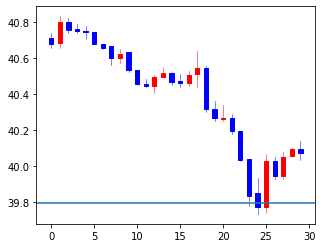

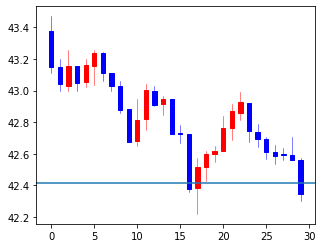

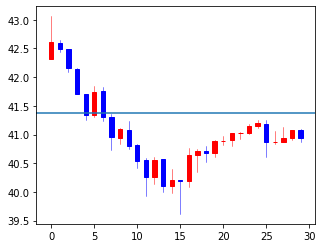

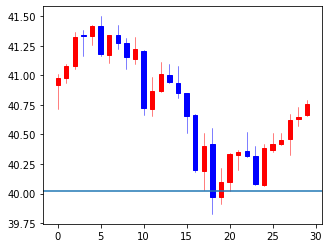

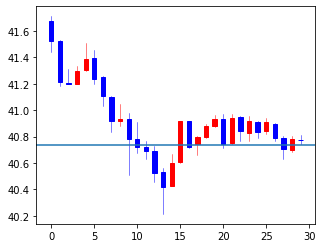

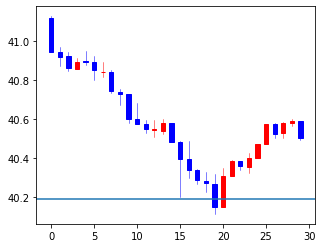

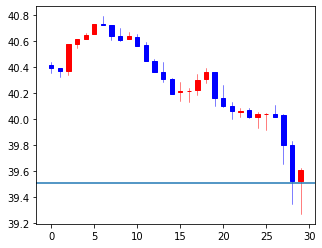

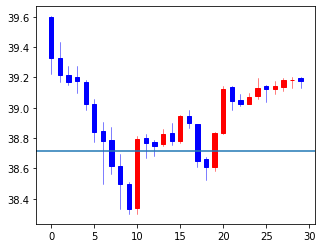

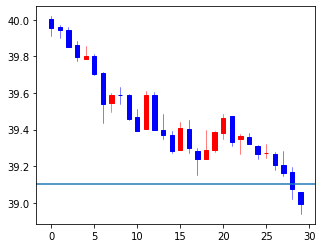

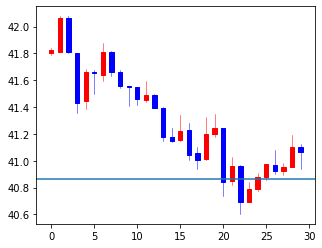

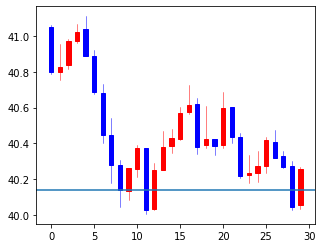

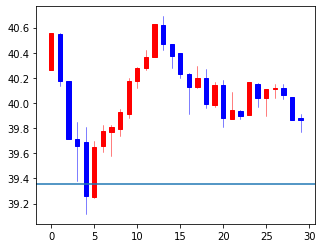

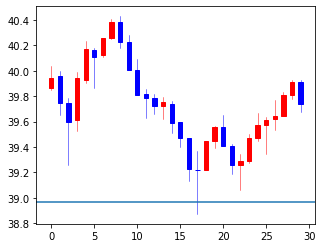

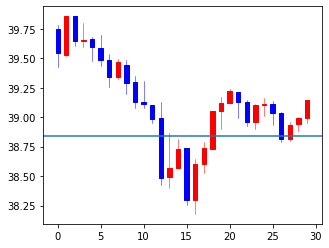

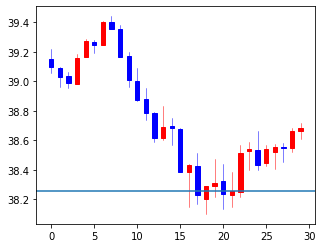

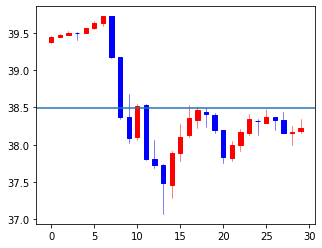

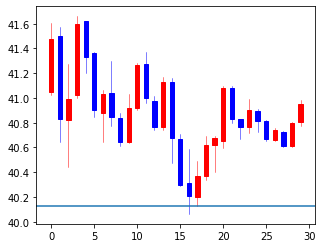

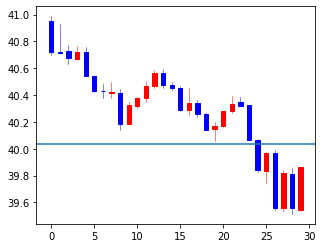

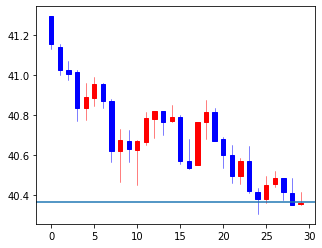

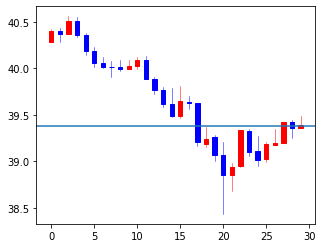

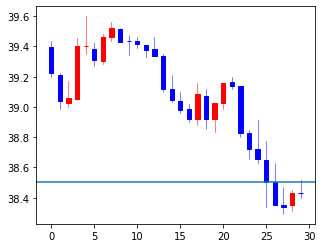

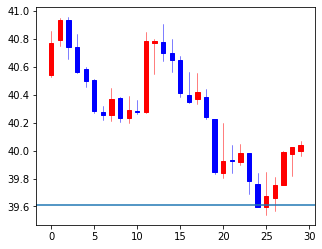

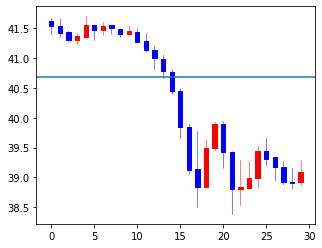

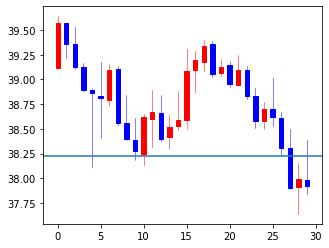

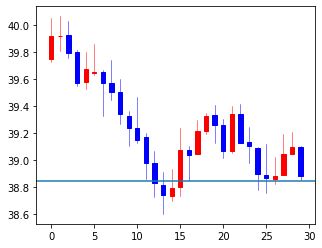

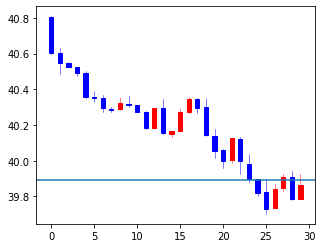

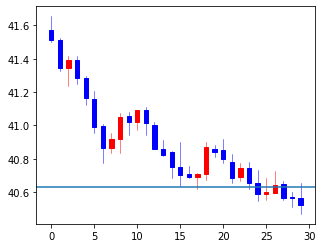

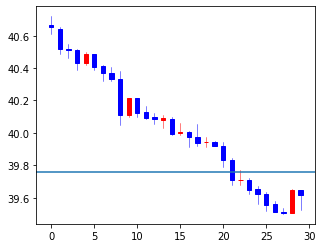

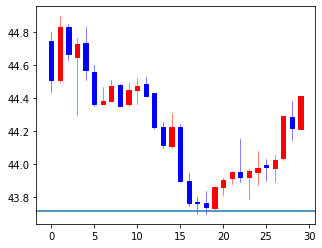

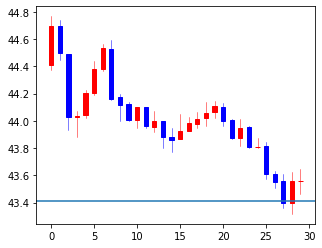

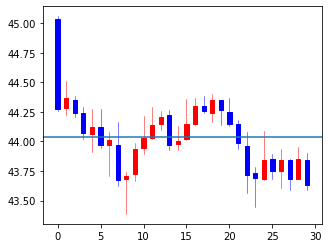

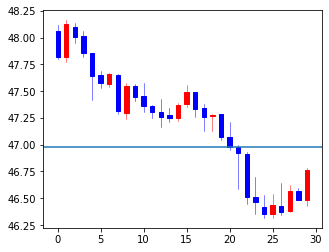

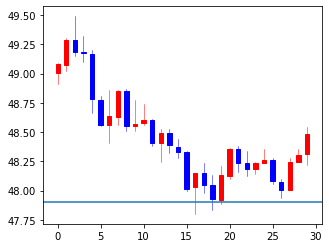

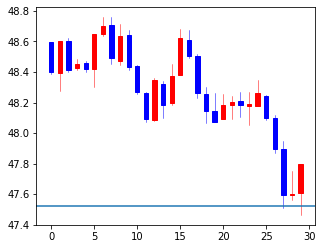

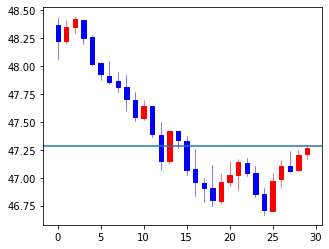

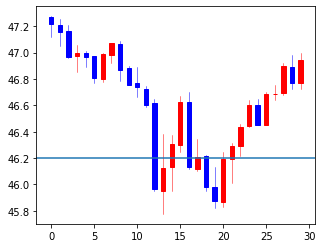

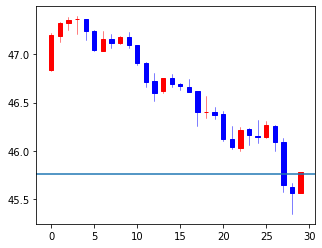

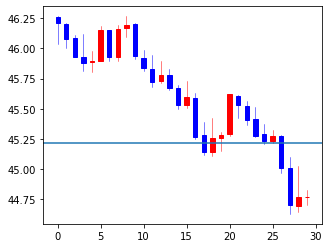

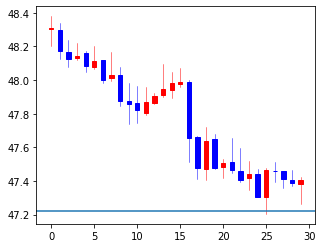

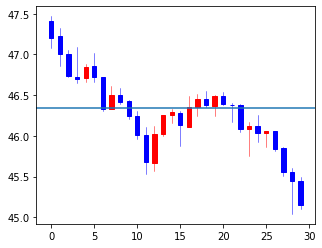

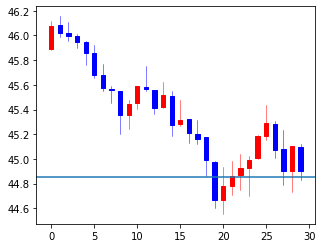

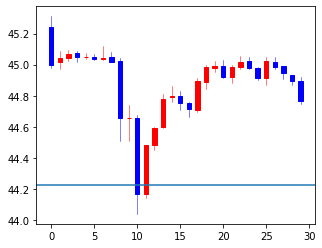

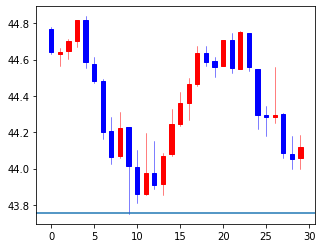

In [34]:
import mpl_finance as mf

print(ohlcv2.index[traded_i])

plot_size = 30

for i in range(plot_size, len(ohlcv2)):

    if i in traded_i:

      fig = plt.figure(figsize=(5, 4))

      # ax = fig.add_subplot(211)
      ax = fig.add_subplot(111)

      ind_temp_ohlc = ohlcv2.iloc[i + 1 - plot_size:i + 1, :4].values

      index = np.arange(len(ind_temp_ohlc))
      candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
      mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

      best_ep2 = best_ep.loc[ohlcv2.index[i]]

      # plt.title(avoid_pr[i])
      plt.axhline(best_ep2)
      plt.show()

### find proper constraint

In [ ]:
sar = lucid_sar(ohlcv)
ha_ohlc = heikinashi(ohlcv).iloc[:, :4]
ema1, ema2, ema3 = ema_ribbon(ohlcv)
senkou1, senkou2 = ichimoku(ohlcv)

#### ichimoku

In [ ]:
test_pr = best_pr
plt.plot(np.cumprod(test_pr))
plt.show()
# break

print(len(test_pr))
print(len(ohlcv))

# avoid_pr = np.where(ohlcv['close'].shift(1) > senkou1.shift(1), test_pr, 1)
avoid_pr = np.where(ohlcv['close'].shift(1) > senkou2.shift(1), test_pr, 1)


plt.plot(np.cumprod(avoid_pr))
plt.show()

#### ha_ohlc

In [ ]:
test_pr = best_pr
plt.plot(np.cumprod(test_pr))
plt.show()
# break

print(len(test_pr))
print(len(ohlcv))

avoid_pr = np.where(ha_ohlc['close'].shift(1) < ha_ohlc['open'].shift(1), test_pr, 1)
# avoid_pr = np.where(ha_ohlc['close'].shift(1) > ha_ohlc['close'].shift(2), test_pr, 1)


plt.plot(np.cumprod(avoid_pr))
plt.show()

#### ema

In [ ]:
test_pr = best_pr
plt.plot(np.cumprod(test_pr))
plt.show()
# break

print(len(test_pr))
print(len(ohlcv))

# for ema_period in range(2, 200):
for ema_period in range(200, 300):
# for ema_period in range(121, 200):

  ema = ohlcv['close'].ewm(span=ema_period, min_periods=ema_period - 1, adjust=False).mean()
  # avoid_pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), test_pr, 1)

  avoid_pr = np.where(ema.shift(1) > ema.shift(2), test_pr, 1)


  plt.plot(np.cumprod(avoid_pr))
  plt.title(ema_period)
  plt.show()


#### sar

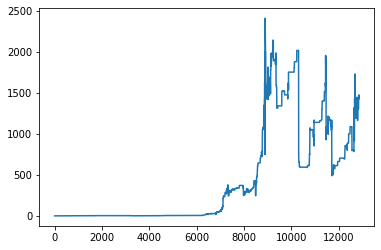

12856
12856


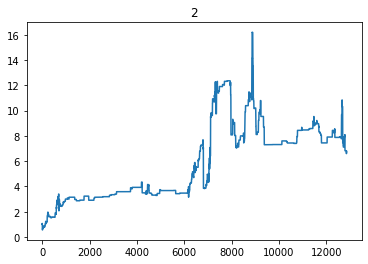

In [ ]:
test_pr = best_pr
plt.plot(np.cumprod(test_pr))
plt.show()
# break

print(len(test_pr))
print(len(ohlcv))

# avoid_pr = np.where(ohlcv['close'].shift(1) < sar.shift(1), test_pr, 1)
avoid_pr = np.where(ohlcv['close'].shift(1) > sar.shift(1), test_pr, 1)

plt.plot(np.cumprod(avoid_pr))
plt.title(ma_period)
plt.show()


#### ma series

In [ ]:
test_pr = best_pr
plt.plot(np.cumprod(test_pr))
plt.show()
# break

print(len(test_pr))
print(len(ohlcv))

#     avoid dropping    #
# for ma_period in range(2, 200):
for ma_period in range(120, 121):
  
  # ma_period = 2

  ma = ohlcv['close'].rolling(ma_period).mean()
  
  # avoid_pr = np.where(ohlcv['close'] > ma, test_pr, 1)
  # avoid_pr = np.where(ohlcv['close'] > ma.shift(1), test_pr, 1)
  # avoid_pr = np.where(ohlcv['close'].shift(1) > ma, test_pr, 1)

  # avoid_pr = np.where(ohlcv['close'].shift(1) > ma.shift(1), test_pr, 1)

  avoid_pr = np.where(ma.shift(1) > ma.shift(2), test_pr, 1)

  # avoid_pr = np.where((ma.shift(1) > ma.shift(2)) & 
  #                     (ma.shift(2) > ma.shift(3)), test_pr, 1)

  avoid_wr = len(avoid_pr[avoid_pr > 1]) / len(avoid_pr[avoid_pr != 1])

  plt.plot(np.cumprod(avoid_pr))
  plt.title('%s\nwr : %.3f' % (ma_period, avoid_wr))
  plt.show()


### constraints v2

In [ ]:
cbo, ema_cbo = cct_bbo(ohlcv, 21, 13) 

_, _, bbw = bb_width(ohlcv, 20, 2) 

fish = fisher(ohlcv, 60)
trix = trix_hist(ohlcv, 14, 1, 5) 
rsi_ = rsi(ohlcv)
macd_hist = macd(ohlcv)

### check the logic

In [ ]:
!pip install mpl_finance

In [ ]:
import mpl_finance as mf

print(len(avoid_pr))
print(len(ohlcv))

plot_size = 28
for i in range(plot_size, len(avoid_pr)):
  
  if avoid_pr[i] != 1:

    fig = plt.figure(figsize=(5, 4))

    # ax = fig.add_subplot(211)
    ax = fig.add_subplot(111)

    ind_temp_ohlc = ohlcv.iloc[i + 1 - plot_size:i + 1, :4].values
    # print("ind_temp_ohlcv.shape :", ind_temp_ohlc.shape)

    index = np.arange(len(ind_temp_ohlc))
    candle = np.hstack((np.reshape(index, (-1, 1)), ind_temp_ohlc))
    mf.candlestick_ohlc(ax, candle, width=0.5, colorup='r', colordown='b')

    # plt.plot(ohlcv.iloc[i + 1 - plot_size:i + 1, :4])
    plt.plot(ma.iloc[i + 1 - plot_size:i + 1].values)
    plt.plot(best_ep.iloc[i + 1 - plot_size:i + 1].values)
    plt.title(avoid_pr[i])
    plt.show()
    break

### short

start_stamp : 0


len(ohlcv) : 12856


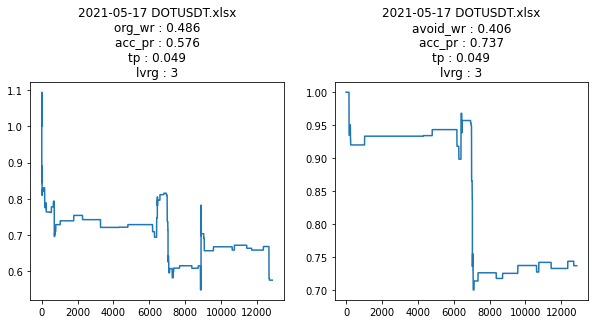

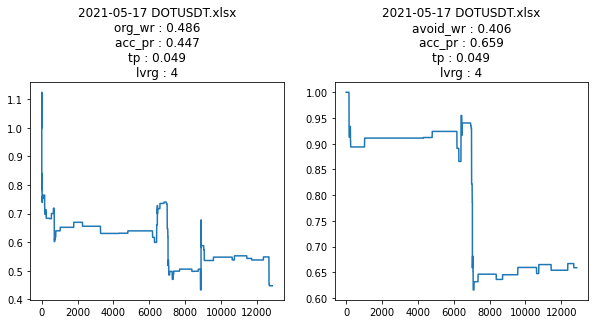

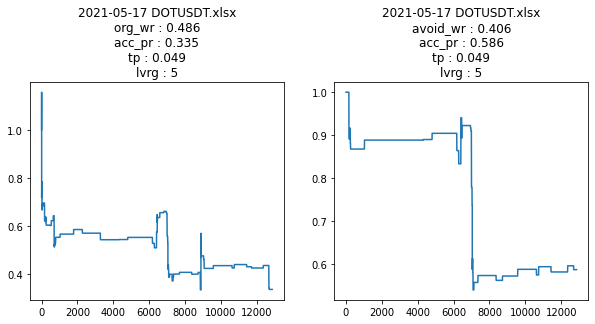

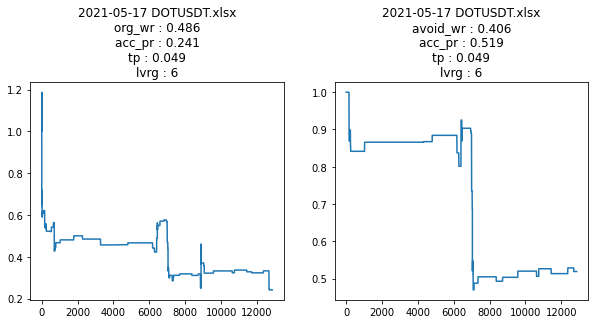

In [ ]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(3, 7)
# lvrg_list = range(1, 2)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:
      
      #       tp opt      #
      best_tp = None
      best_ap = 0
      best_pr = None

      #        find best tp       #
      for tp in tp_list:

        # long_ep = ohlcv['close'].shift(1) * (1 / (tp + 1))

        # #       long      #
        # pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        # #     set condition   #
        # pr = np.where(ohlcv['low'] < long_ep, pr, 1)
      
        # lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        short_ep = ohlcv['close'].shift(1) * (1 / (1 - tp))

        #       short       #
        pr = (short_ep / ohlcv['close'] - fee - 1) * lvrg + 1
        pr = np.where(ohlcv['high'] > short_ep, pr, 1)

        lq = (short_ep / ohlcv['high'] - fee - 1) * lvrg + 1


        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)
        # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

        # plt.plot(np.cumprod(pr))
        # plt.title("%.3f" % tp)
        # plt.show()
        # plt.close()

        ap = np.cumprod(pr)[-1]
        if ap >= best_ap:
          best_ap = ap
          best_tp = tp
          best_pr = pr

      best_pr = np.array(best_pr)
      org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

      plt.figure(figsize=(10, 4))
      plt.subplot(121)
      plt.plot(np.cumprod(best_pr))
      plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))

      
      #     avoid dropping    #
      ma = ohlcv['close'].rolling(120).mean()
      avoid_pr = np.where(ma.shift(1) > ma.shift(2), best_pr, 1)

      avoid_wr = len(avoid_pr[avoid_pr > 1]) / len(avoid_pr[avoid_pr != 1])

      
      plt.subplot(122)
      plt.plot(np.cumprod(avoid_pr))
      plt.title("%s\navoid_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, avoid_wr, np.cumprod(avoid_pr)[-1], best_tp, lvrg))

      plt.show()








### dynamic tp

#### stack prev data

start_stamp : 0


len(ohlcv) : 12856


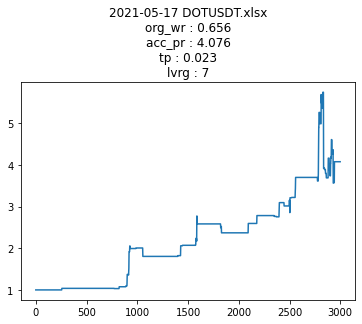

In [ ]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(1, 2)
lvrg_list = range(7, 8)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:

      test_size = 3000

      #       do basic survey for comparison      #
      #       tp opt      #
      best_tp = None
      best_ap = 0
      best_pr = None

      #        find best tp       #
      for tp in tp_list:

        long_ep = ohlcv['close'].shift(1) * (1 / (tp + 1))

        #       long      #
        pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(ohlcv['low'] < long_ep, pr, 1)
      
        lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        ema = ohlcv['close'].ewm(span=190, min_periods=190-1, adjust=False).mean()
        # pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), pr, 1)
        pr = np.where(ema.shift(1) > ema.shift(2), pr, 1)

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       short       #
        # s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)
        # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

        # plt.plot(np.cumprod(pr))
        # plt.title("%.3f" % tp)
        # plt.show()
        # plt.close()

        wr = len(pr[pr > 1]) / len(pr[pr != 1])

        ap = np.cumprod(pr)[-1]
        # if ap >= best_ap:
        if ap >= best_ap and wr > 0.65:

          best_ep = long_ep
          best_ap = ap
          best_tp = tp
          best_pr = pr

      best_pr = np.array(best_pr)
      org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

      # plt.figure(figsize=(10, 4))
      # plt.subplot(121)
      plt.plot(np.cumprod(best_pr[-test_size:]))
      plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr[-test_size:])[-1], best_tp, lvrg))
      plt.show()


      # look_back_size = 3000
      test_pr_result = []
      best_tp_list = []

      for t_i in tqdm(range(test_size - 1)):

        last2_ohlcv = ohlcv.iloc[-test_size + t_i - 1:-test_size + t_i + 1]
    
        #     find best_tp by back ohlcv  #
        back_ohlcv = ohlcv.iloc[:-test_size + t_i]

        #       tp opt      #
        best_tp = None
        best_ap = 0
        best_pr = None

        #        find best tp       #
        for tp in tp_list:

          long_ep = back_ohlcv['close'].shift(1) * (1 / (tp + 1))

          #       long      #
          pr = (back_ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
          #     set condition   #
          pr = np.where(back_ohlcv['low'] < long_ep, pr, 1)
        
          lq = (back_ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

          ema = back_ohlcv['close'].ewm(span=190, min_periods=190-1, adjust=False).mean()
          # pr = np.where(ohlcv['close'].shift(1) > ema.shift(1), pr, 1)
          pr = np.where(ema.shift(1) > ema.shift(2), pr, 1)


          # plt.plot(np.cumprod(pr))
          # plt.show()
          # break

          #       short       #
          # s_pr = (-back_ohlcv['close'].pct_change() - fee) * lvrg + 1

          #       fill na with 1.0      #
          pr = np.where(np.isnan(pr), 1, pr)
          # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
          lq = np.where(np.isnan(lq), 1, lq)
          # s_pr = np.where(np.isnan(s_pr), 1, pr)

          #       set lq      #
          pr = np.where((pr != 1) & (lq <= 0), 0, pr)
          # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

          # plt.plot(np.cumprod(pr))
          # plt.title("%.3f" % tp)
          # plt.show()
          # plt.close()
          wr = len(pr[pr > 1]) / len(pr[pr != 1])

          ap = np.cumprod(pr)[-1]
          # if ap >= best_ap:
          if ap >= best_ap and wr > 0.65:
            
            best_ap = ap
            best_tp = tp
            best_pr = pr

        
        best_tp_list.append(best_tp)
        best_pr = np.array(best_pr)
        org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

        # print("best_tp :", best_tp)

        long_ep = last2_ohlcv['close'].shift(1) * (1 / (best_tp + 1))

        pr = (last2_ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(last2_ohlcv['low'] < long_ep, pr, 1)
      
        lq = (last2_ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)

        # plt.figure(figsize=(10, 4))
        # plt.subplot(121)
        # plt.plot(np.cumprod(best_pr))
        # plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))
       
        test_pr_result.append(pr[-1])

      print("len(test_pr_result) :", len(test_pr_result))

      test_pr_result = np.array(test_pr_result)

      wr = len(test_pr_result[test_pr_result > 1]) / len(test_pr_result[test_pr_result != 1])

      plt.plot(np.cumprod(test_pr_result))
      plt.title("%s\nwr : %.3f\nacc_pr : %.3f\nlvrg : %s" % (key, wr, np.cumprod(test_pr_result)[-1],lvrg))

      plt.show()

      plt.plot(best_tp_list)
      plt.title("best_tp_list")

      plt.show()


In [ ]:
test_pr_result = np.array(test_pr_result)

wr = len(test_pr_result[test_pr_result > 1]) / len(test_pr_result[test_pr_result != 1])

plt.plot(np.cumprod(test_pr_result))
plt.title("%s\wr : %.3f\nacc_pr : %.3f\nlvrg : %s" % (key, wr, np.cumprod(test_pr_result)[-1],lvrg))

plt.show()

plt.plot(best_tp_list)
plt.title("best_tp_list")

plt.show()

#### local opt

start_stamp : 0


len(ohlcv) : 12856



len(test_pr_result) : 2999


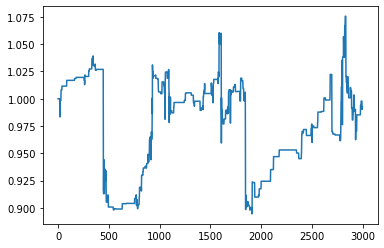

In [ ]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(1, 2)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'dot'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))

    #     find best lvrg with lq    #
    for lvrg in lvrg_list:

      test_size = 3000
      look_back_size = 3000
      test_pr_result = []

      for t_i in tqdm(range(test_size - 1)):

        last2_ohlcv = ohlcv.iloc[-test_size + t_i - 1:-test_size + t_i + 1]
    
        #     find best_tp by back ohlcv  #

        back_ohlcv = ohlcv.iloc[-test_size - look_back_size + t_i:-test_size + t_i]

        #       tp opt      #
        best_tp = None
        best_ap = 0
        best_pr = None

        #        find best tp       #
        for tp in tp_list:

          long_ep = back_ohlcv['close'].shift(1) * (1 / (tp + 1))

          #       long      #
          pr = (back_ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
          #     set condition   #
          pr = np.where(back_ohlcv['low'] < long_ep, pr, 1)
        
          lq = (back_ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

          # plt.plot(np.cumprod(pr))
          # plt.show()
          # break

          #       short       #
          # s_pr = (-back_ohlcv['close'].pct_change() - fee) * lvrg + 1

          #       fill na with 1.0      #
          pr = np.where(np.isnan(pr), 1, pr)
          # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
          lq = np.where(np.isnan(lq), 1, lq)
          # s_pr = np.where(np.isnan(s_pr), 1, pr)

          #       set lq      #
          pr = np.where((pr != 1) & (lq <= 0), 0, pr)
          # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

          # plt.plot(np.cumprod(pr))
          # plt.title("%.3f" % tp)
          # plt.show()
          # plt.close()

          ap = np.cumprod(pr)[-1]
          if ap >= best_ap:
            best_ap = ap
            best_tp = tp
            best_pr = pr

        best_pr = np.array(best_pr)
        org_wr = len(best_pr[best_pr > 1]) / len(best_pr[best_pr != 1])

        # print("best_tp :", best_tp)

        long_ep = last2_ohlcv['close'].shift(1) * (1 / (best_tp + 1))

        pr = (last2_ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
        #     set condition   #
        pr = np.where(last2_ohlcv['low'] < long_ep, pr, 1)
      
        lq = (last2_ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

        # plt.plot(np.cumprod(pr))
        # plt.show()
        # break

        #       fill na with 1.0      #
        pr = np.where(np.isnan(pr), 1, pr)
        # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
        lq = np.where(np.isnan(lq), 1, lq)
        # s_pr = np.where(np.isnan(s_pr), 1, pr)

        #       set lq      #
        pr = np.where((pr != 1) & (lq <= 0), 0, pr)

        # plt.figure(figsize=(10, 4))
        # plt.subplot(121)
        # plt.plot(np.cumprod(best_pr))
        # plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))

        
        # #     avoid dropping    #
        # # ma = back_ohlcv['close'].rolling(120).mean()
        # # avoid_pr = np.where(ma.shift(1) > ma.shift(2), best_pr, 1)

        # # avoid_wr = len(avoid_pr[avoid_pr > 1]) / len(avoid_pr[avoid_pr != 1])

        
        # # plt.subplot(122)
        # # plt.plot(np.cumprod(avoid_pr))
        # # plt.title("%s\navoid_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, avoid_wr, np.cumprod(avoid_pr)[-1], best_tp, lvrg))

        # plt.show()

        test_pr_result.append(pr[-1])

      print("len(test_pr_result) :", len(test_pr_result))

      plt.plot(np.cumprod(test_pr_result))
      plt.show()








Text(0.5, 1.0, '2021-05-17 DOTUSDT.xlsx\norg_wr : 0.613\nacc_pr : 1.187\ntp : 0.023\nlvrg : 1')

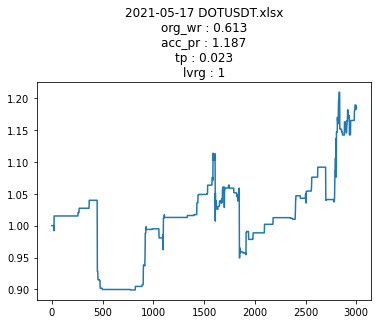

In [ ]:
plt.plot(np.cumprod(best_pr[-test_size:]))
plt.title("%s\norg_wr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))


#### check flucutation

len(ohlcv) : 18984


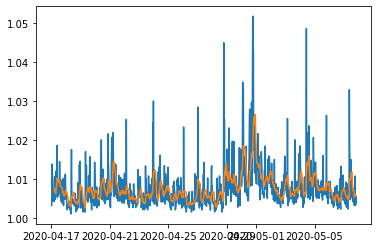

In [ ]:
   
ohlcv = pd.read_excel(date_path + key, index_col=0)
print('len(ohlcv) :', len(ohlcv))

fluc = ohlcv['high'] / ohlcv['low']

ma_period = 10
fluc_ma = fluc.rolling(ma_period).mean()

# plt.plot(ohlcv['close'])
plot_size = 1000
plt.plot(fluc[:plot_size])
plt.plot(fluc_ma[:plot_size])
plt.show()

start_stamp : 0


len(ohlcv) : 18984


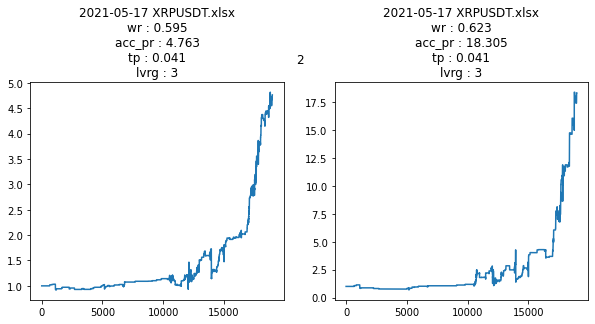

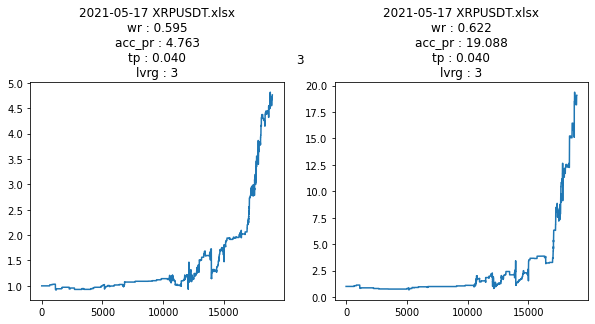

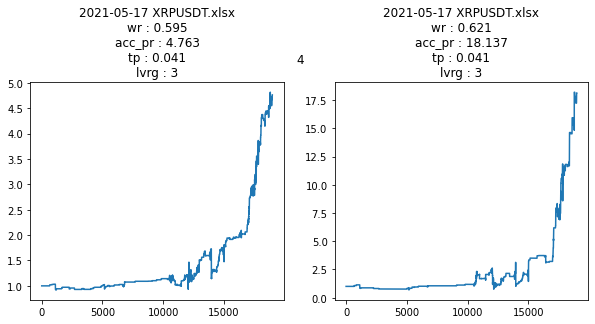

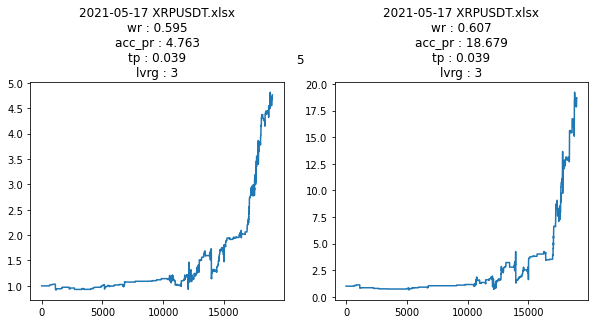

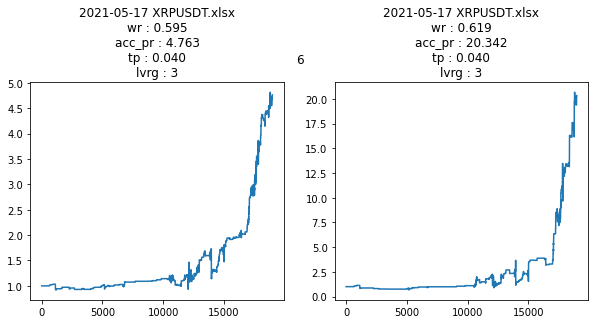

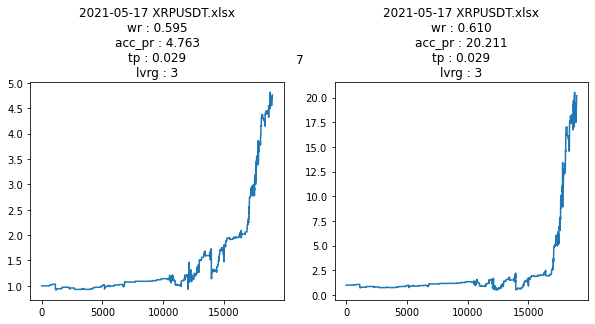

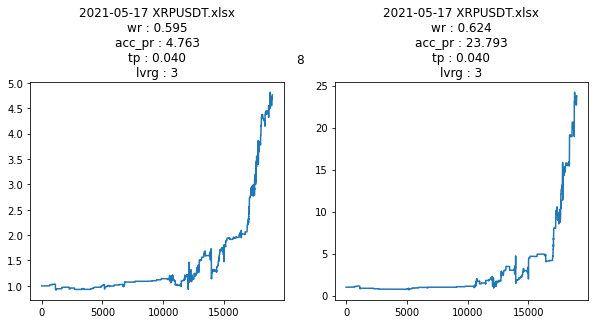

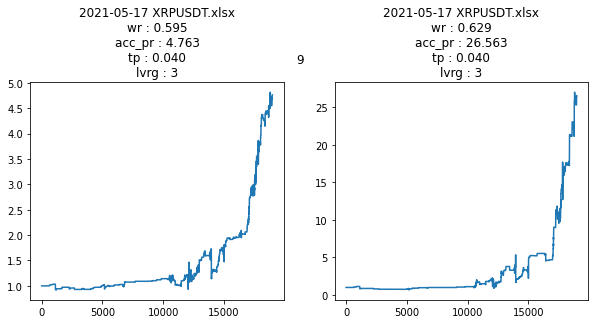

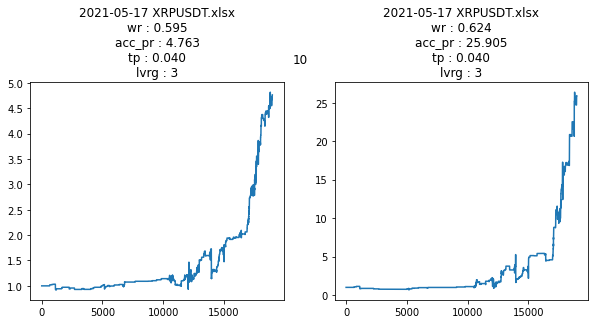

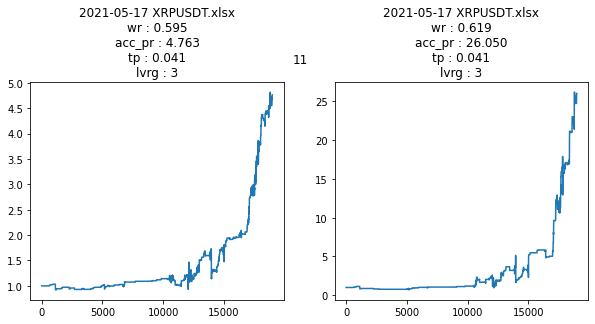

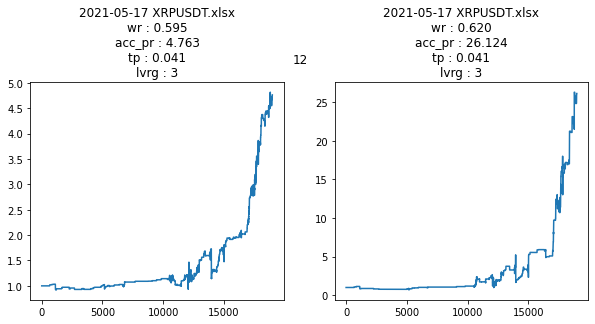

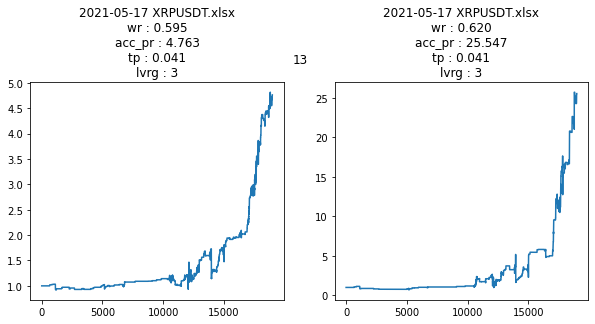

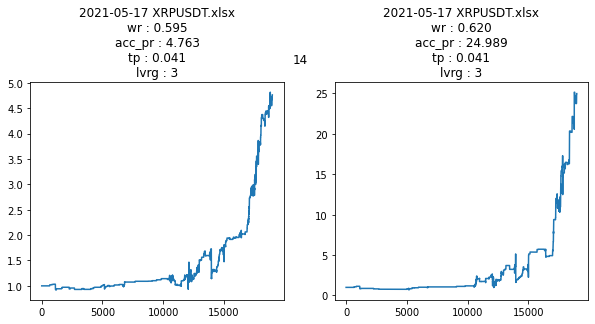

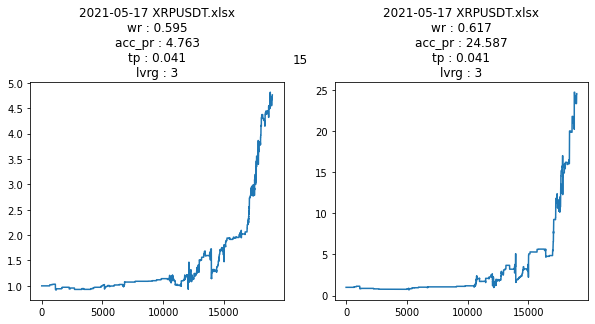

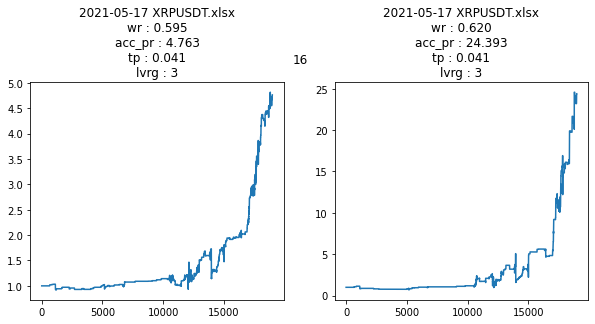

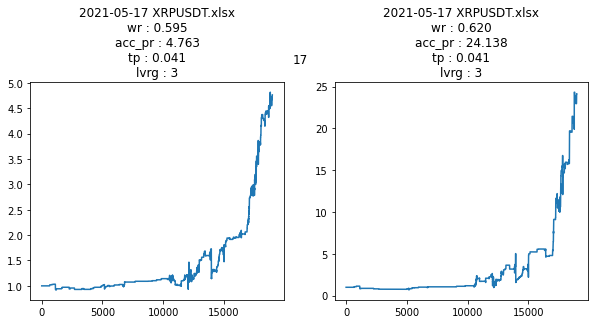

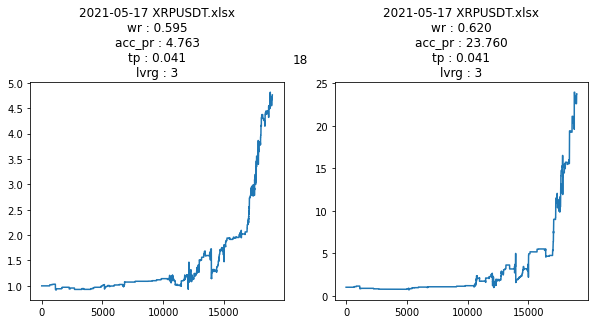

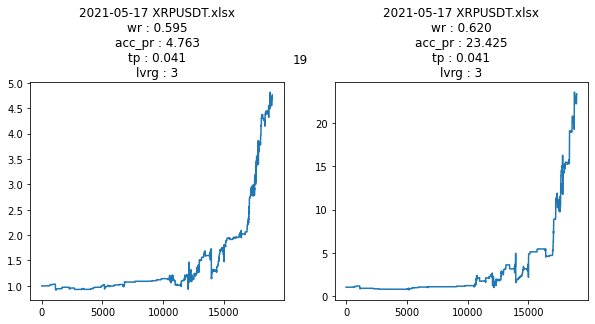

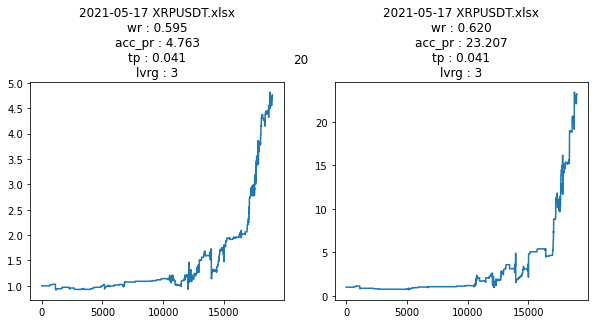

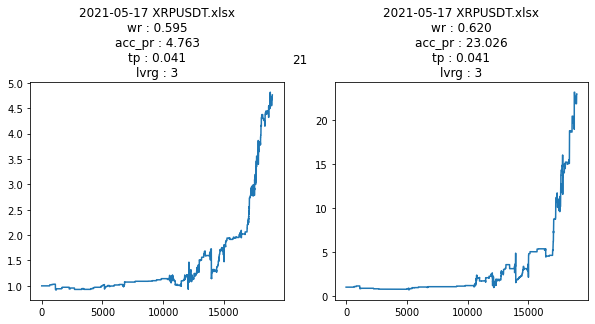

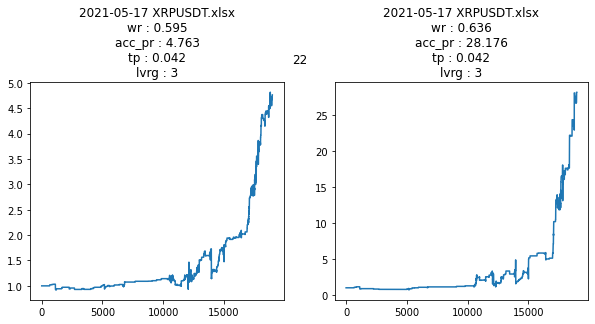

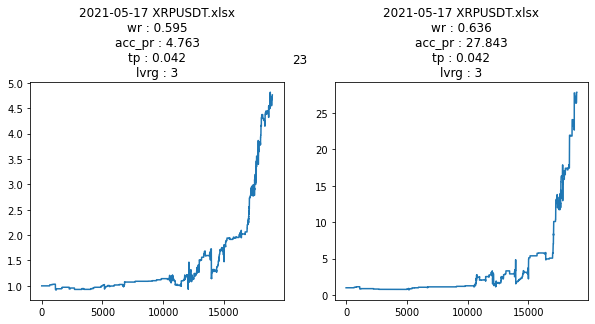

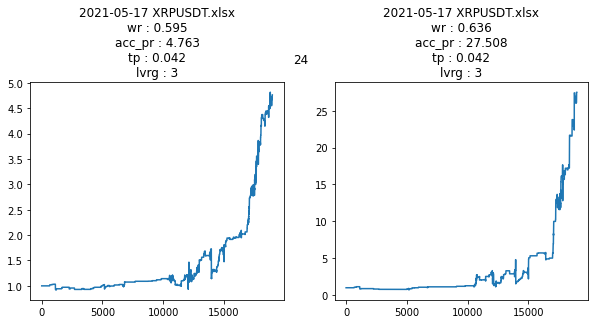

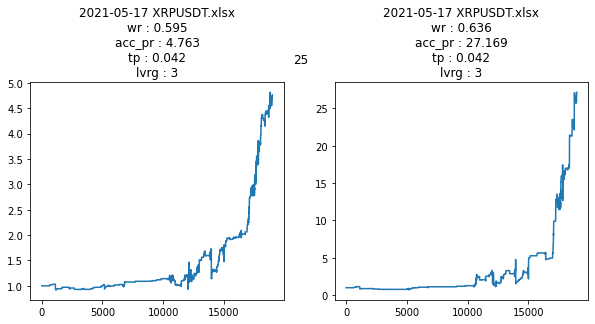

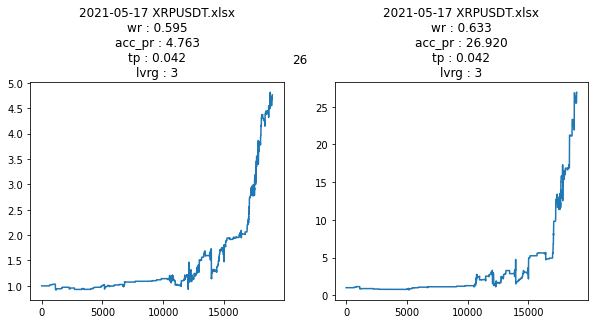

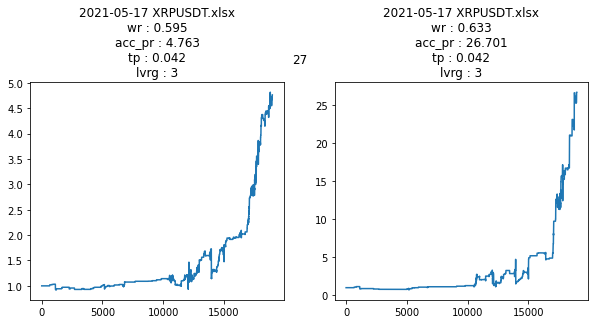

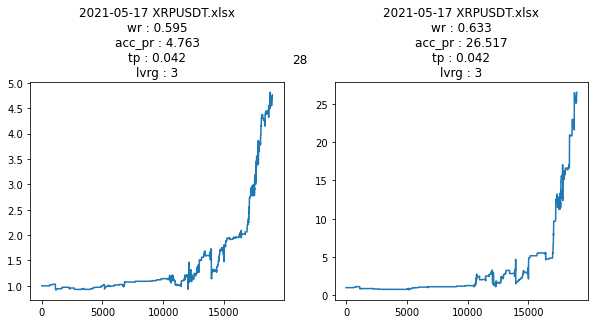

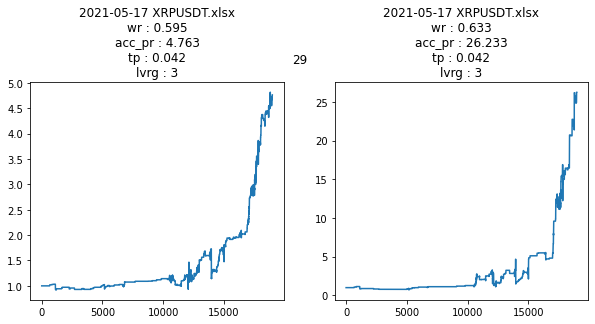

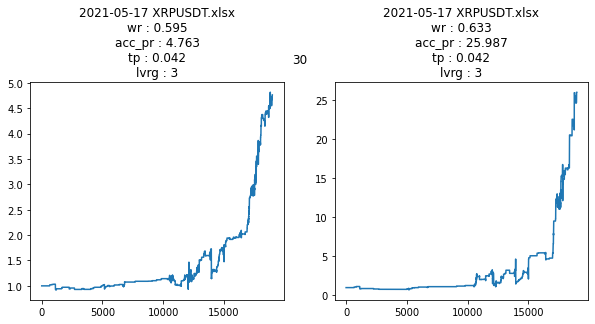

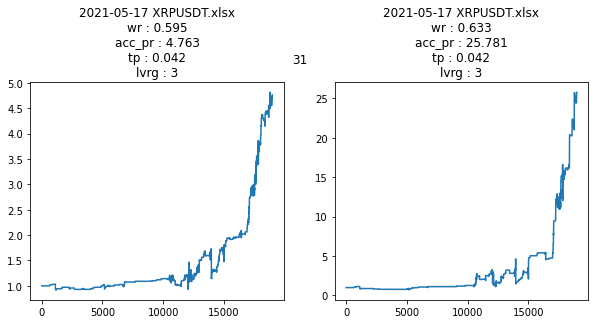

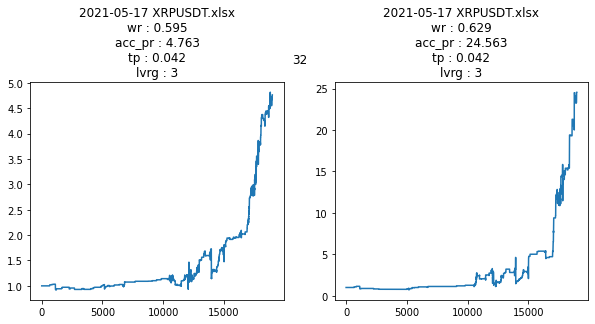

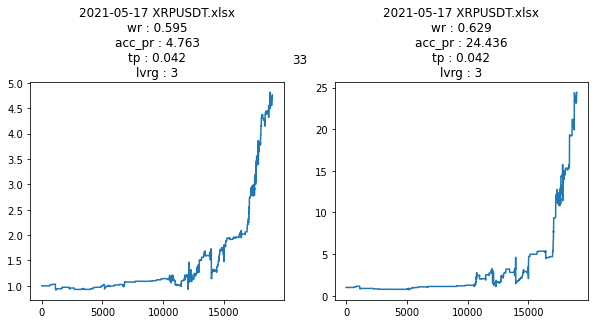

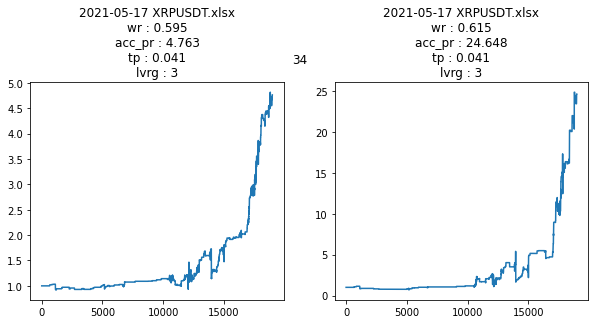

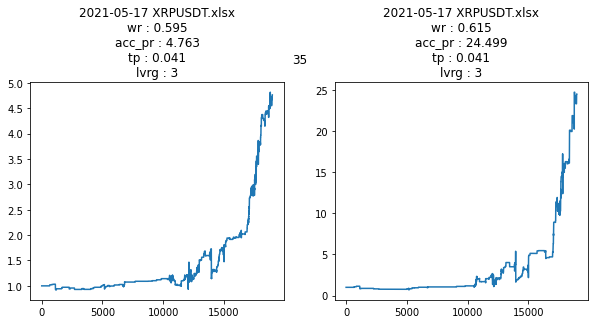

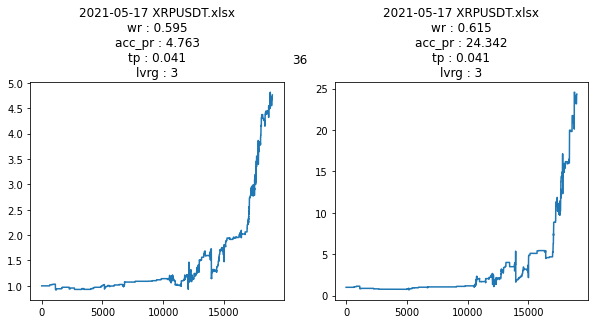

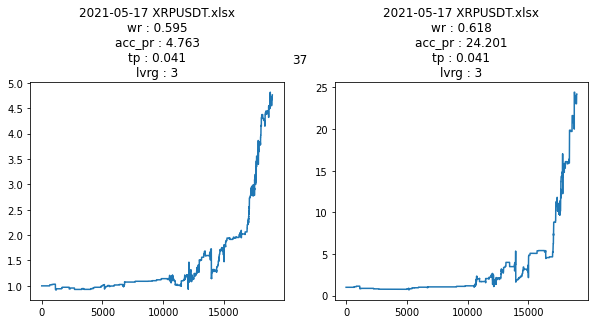

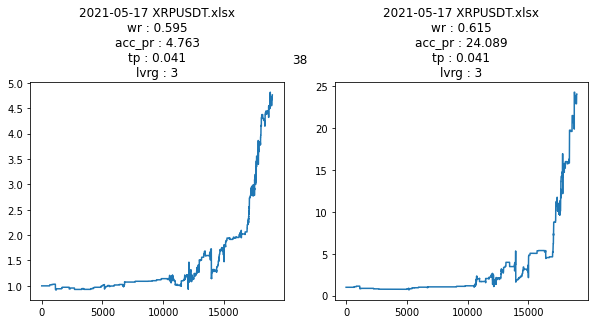

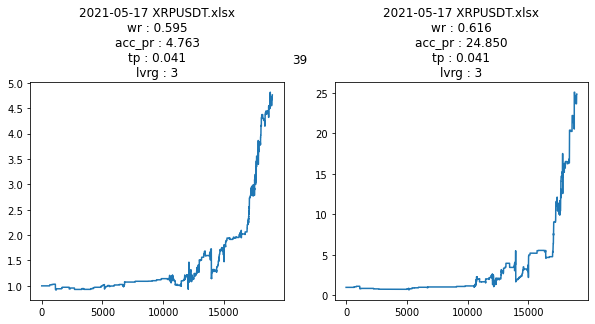

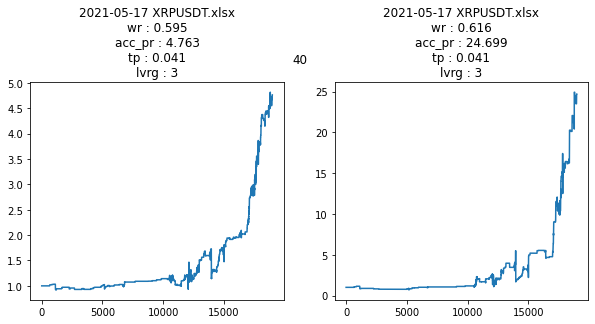

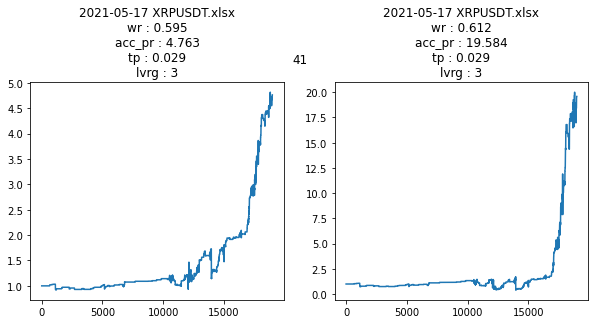

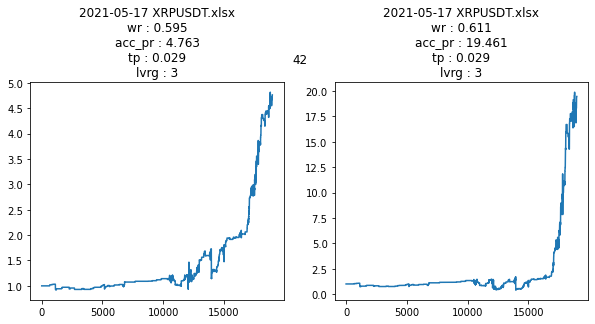

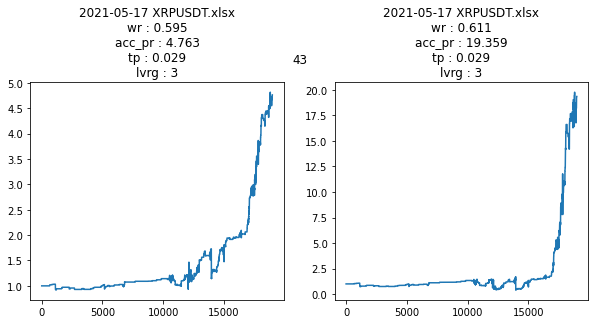

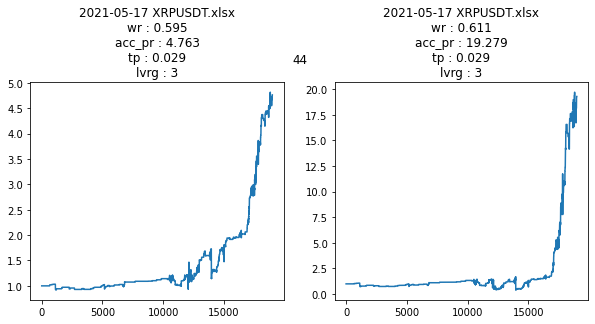

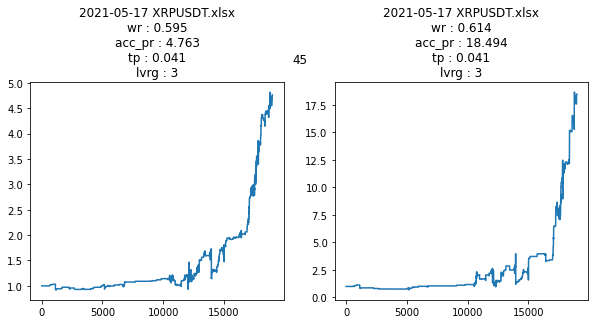

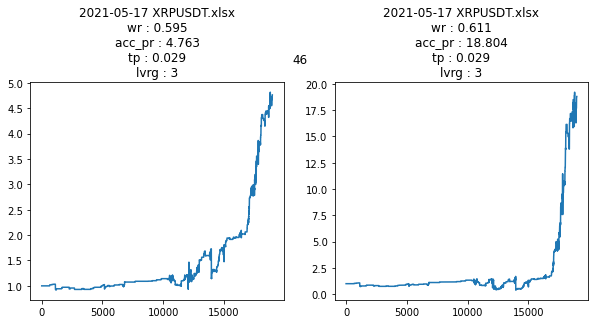

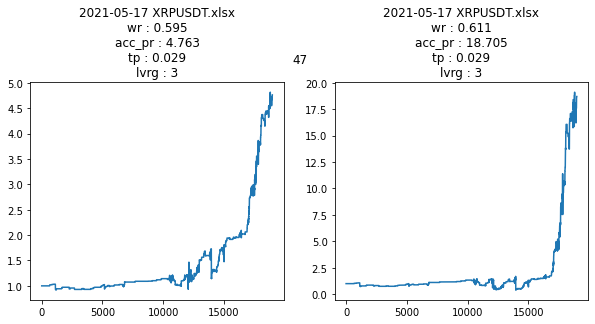

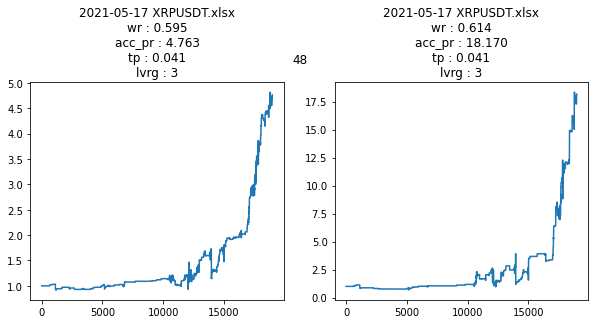

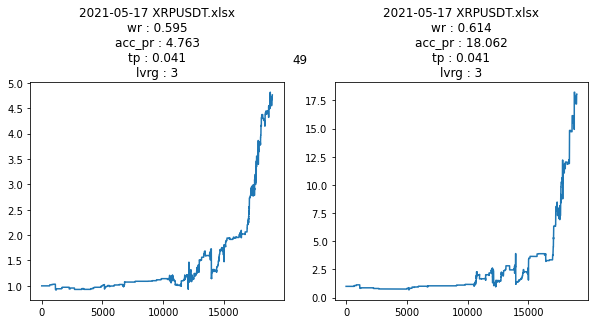

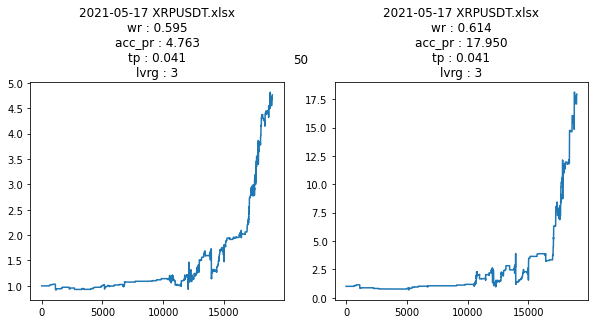

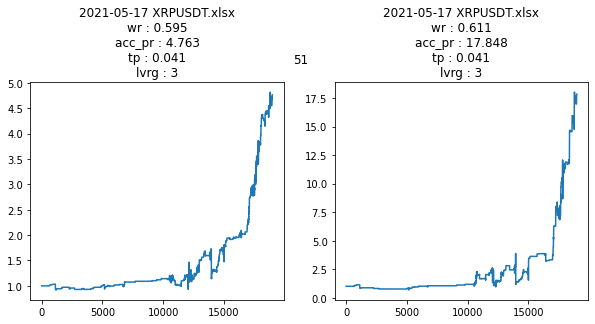

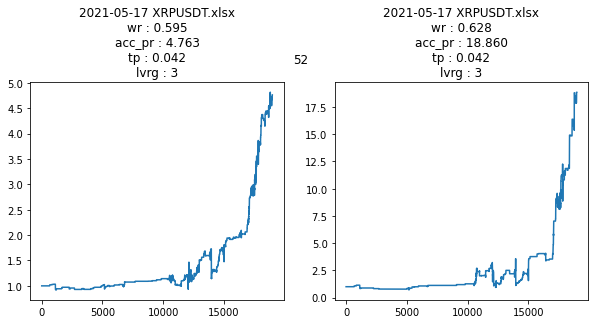

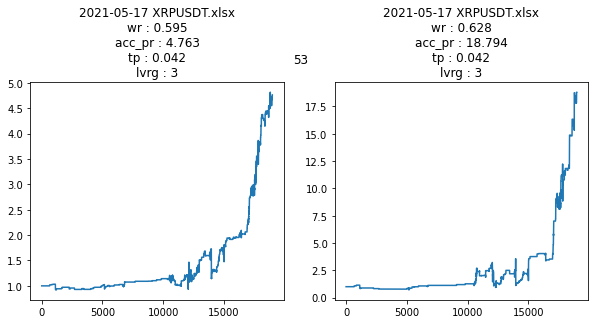

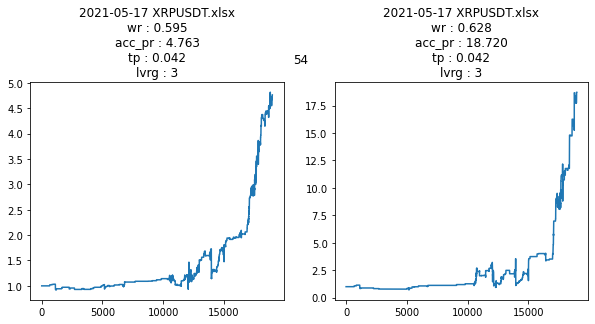

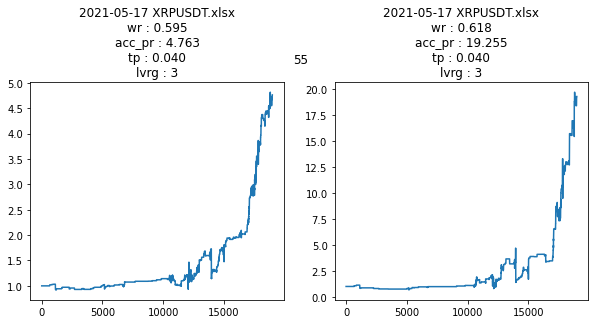

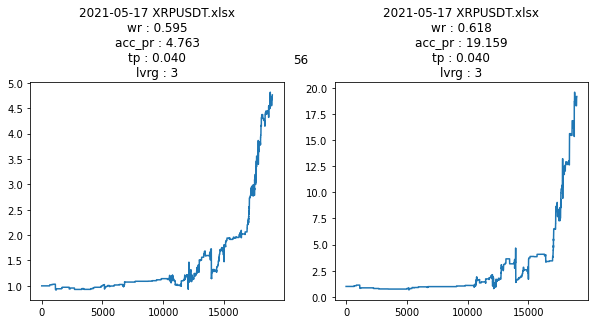

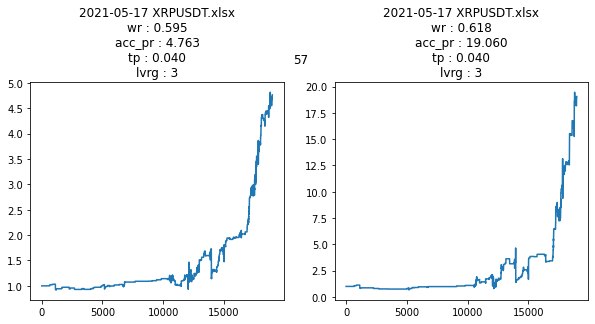

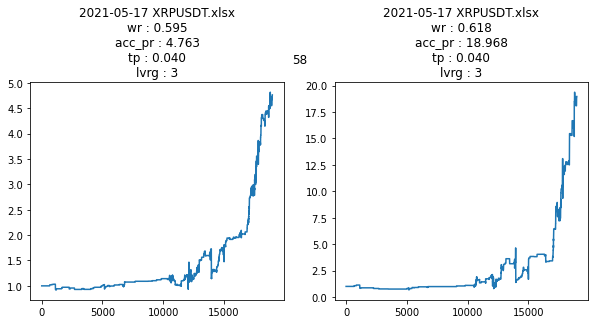

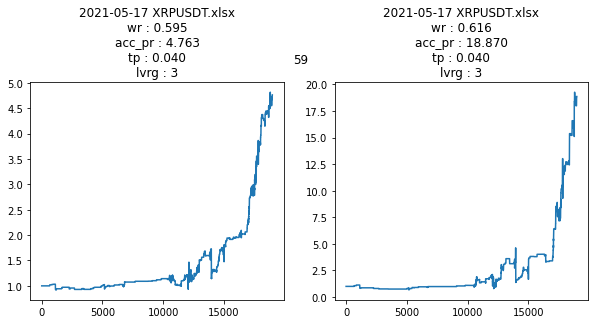

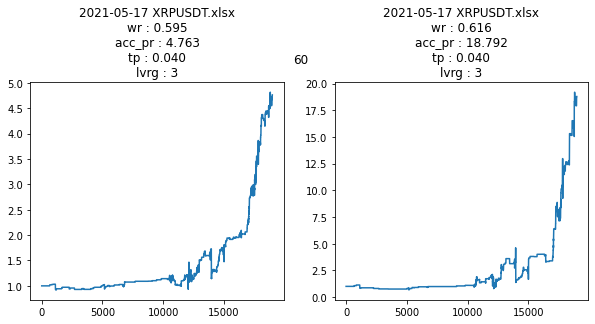

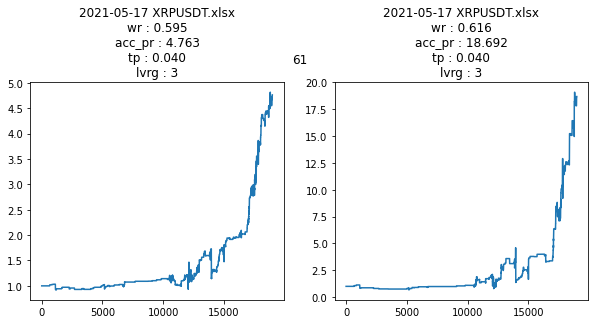

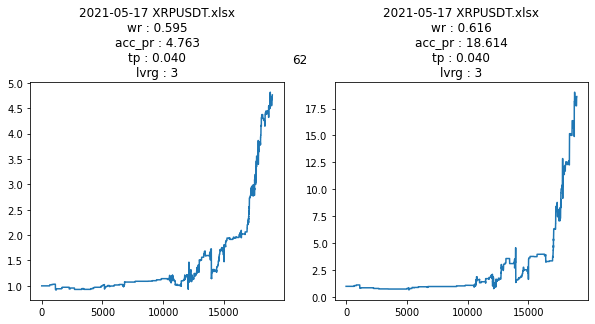

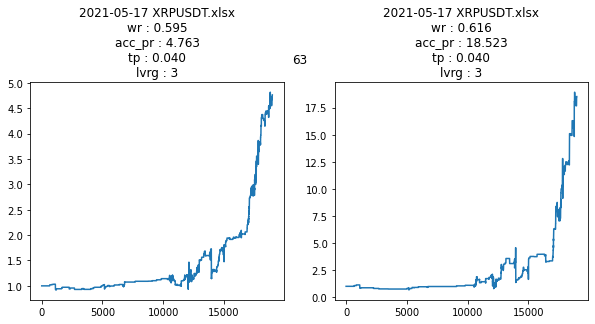

KeyboardInterrupt: ignored

In [ ]:
from tqdm.notebook import tqdm
from funcs_indicator import *
import matplotlib.pyplot as plt

# import mpl_finance as mf


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


start_stamp = 0
# start_stamp = datetime.timestamp(pd.to_datetime('2021-02-12'))
print("start_stamp :", start_stamp)
# break

np.random.shuffle(file_list)
candis = file_list

prev_x = None
total_x = None

seed = 1
random_state = 201
np.random.seed(seed)

fee = 0.0006
lvrg = 1

tp_list = np.arange(0.0, 0.05, 0.001)
lvrg_list = range(1, 10)
lvrg_list = range(3, 4)

for i in tqdm(range(len(candis))):

  keys = [candis[i]]

  if 'xrp'.upper() not in candis[i]:
    continue

  for key in keys:  
    
    ohlcv = pd.read_excel(date_path + key, index_col=0)
    print('len(ohlcv) :', len(ohlcv))
    
    fluc = ohlcv['high'] / ohlcv['low']

    for ma_period in range(2, 100):
      # ma_period = 10
      fluc_ma = fluc.rolling(ma_period).mean()

      #     find best lvrg with lq    #
      for lvrg in lvrg_list:
        
        #       tp opt      #
        best_tp = None
        best_ap = 0
        best_pr2 = None

        #        find best tp       #
        for tp in tp_list:

          long_ep = ohlcv['close'].shift(1) * (1 / (fluc_ma.shift(1) * tp + 1))

          #       long      #
          pr = (ohlcv['close'] / long_ep - fee - 1) * lvrg + 1
          #     set condition   #
          pr = np.where(ohlcv['low'] < long_ep, pr, 1)
        
          lq = (ohlcv['low'] / long_ep - fee - 1) * lvrg + 1

          # plt.plot(np.cumprod(pr))
          # plt.show()
          # break

          #       short       #
          # s_pr = (-ohlcv['close'].pct_change() - fee) * lvrg + 1

          #       fill na with 1.0      #
          pr = np.where(np.isnan(pr), 1, pr)
          # avoid_pr = np.where(np.isnan(avoid_pr), 1, avoid_pr)
          lq = np.where(np.isnan(lq), 1, lq)
          # s_pr = np.where(np.isnan(s_pr), 1, pr)

          #       set lq      #
          pr = np.where((pr != 1) & (lq <= 0), 0, pr)
          # avoid_pr = np.where((avoid_pr != 1) & (lq <= 0), 0, avoid_pr)

          # plt.plot(np.cumprod(pr))
          # plt.title("%.3f" % tp)
          # plt.show()
          # plt.close()

          ap = np.cumprod(pr)[-1]
          if ap >= best_ap:
            best_ap = ap
            best_tp = tp
            best_pr2 = pr

        best_pr2 = np.array(best_pr2)
        org_wr2 = len(best_pr2[best_pr2 > 1]) / len(best_pr2[best_pr2 != 1])

        plt.figure(figsize=(10, 4))

        plt.suptitle(ma_period)

        plt.subplot(121)
        plt.plot(np.cumprod(best_pr))
        plt.title("%s\nwr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr, np.cumprod(best_pr)[-1], best_tp, lvrg))
        
        plt.subplot(122)
        plt.plot(np.cumprod(best_pr2))
        plt.title("%s\nwr : %.3f\nacc_pr : %.3f\ntp : %.3f\nlvrg : %s" % (key, org_wr2, np.cumprod(best_pr2)[-1], best_tp, lvrg))
        
        plt.show()








### sl cut parts

In [ ]:
plt.plot(np.cumprod(test_pr))
plt.show()

#                  sl cut                #
for period in range(200, 201):
  
  sl_line = ohlcv['low'].rolling(period).min()
  # sl_line = long_ep * 0.7
  # sl_line = ohlcv['low'].shift(1)
  sl_pr = 1 + lvrg * (sl_line / long_ep - 1 - fee)
  # plt.plot(sl_pr)
  # plt.show()
  # # break

  # plt.plot(test_pr)
  # plt.show()
  test_pr_sl = np.where((test_pr != 1) & (sl_line > ohlcv['low']) & (1 > sl_line), sl_pr, test_pr)

  # plt.plot(test_pr_sl)
  # plt.show()
  # break

  wr_sl = len(test_pr_sl[test_pr_sl > 1]) / len(test_pr_sl[test_pr_sl != 1])

  # plt.subplot(122)
  plt.plot(np.cumprod(test_pr_sl))
  plt.title("%s\norg_wr : %.3f\n wr : %.5f\nacc_pr : %.3f\nperiod : %s" % (key, org_wr, wr_sl, np.cumprod(test_pr_sl)[-1], period))
  plt.show()
